<a href="https://colab.research.google.com/github/sayanbanerjee32/landmark-recognition-2021/blob/main/landmark-recognition-2021-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
# To import kaggle datasets
# !pip install -q kaggle
!pip uninstall -y kaggle
!pip install --upgrade pip 
!pip install kaggle==1.5.6

In [ ]:
# import colab libraries
from google.colab import files
# import kaggle json to connect to kaggle user account to download datsets
files.upload()

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# download our dataset
!kaggle competitions download -c 'landmark-recognition-2021' --force

In [ ]:
# unzip training set to `train` folder
!unzip landmark-recognition-2021.zip "train.csv" -d landmark-recognition-2021
!unzip landmark-recognition-2021.zip "train/*" -d landmark-recognition-2021

In [ ]:
# create output dir
!mkdir models

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
cur_time = datetime.now().strftime("%Y%m%d%H%M%S")
print(f"Run time {cur_time}")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for i, (dirname, _, filenames) in enumerate(os.walk('/kaggle/input')):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    if i > 1: break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Run time 20210907084512
/kaggle/input/landmark-recognition-2021/sample_submission.csv
/kaggle/input/landmark-recognition-2021/train.csv


In [ ]:
os.getcwd()

'/kaggle/working'

In [ ]:
base_data_dir = '/content/landmark-recognition-2021/'
train_dir = 'train'
test_dir = 'test'
output_dir = '/content/'
output_model_dir = 'models'

In [ ]:
train_csv = pd.read_csv(base_data_dir +'/train.csv')
train_csv.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [ ]:
len(train_csv.landmark_id.unique())

81313

In [ ]:
def add_file_path(df, train_test_dir, return_order = ['id','path','landmark_id']):
    df['path'] = df['id'].apply(lambda x:train_test_dir + '/' +\
                                '/'.join(x[0:3]) + '/' + x + '.jpg')
    df['landmark_id'] = df['landmark_id'].astype(str)
    return df[return_order]
train_csv = add_file_path(train_csv, train_test_dir = train_dir)
train_csv.head()

,id,path,landmark_id
0,17660ef415d37059,train/1/7/6/17660ef415d37059.jpg,1
1,92b6290d571448f6,train/9/2/b/92b6290d571448f6.jpg,1
2,cd41bf948edc0340,train/c/d/4/cd41bf948edc0340.jpg,1
3,fb09f1e98c6d2f70,train/f/b/0/fb09f1e98c6d2f70.jpg,1
4,25c9dfc7ea69838d,train/2/5/c/25c9dfc7ea69838d.jpg,7


In [ ]:
from sklearn.model_selection import StratifiedKFold
tr_ids, val_ids = next(StratifiedKFold(n_splits=5).split(train_csv.id, train_csv.landmark_id))
len(val_ids),len(tr_ids),len(train_csv)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


(316094, 1264376, 1580470)

In [ ]:
dummy = [False] * len(train_csv)
is_valid = [value if index not in val_ids else True for index, value in enumerate(dummy)]
sum(is_valid)

316094

In [ ]:
train_csv['is_valid'] = is_valid
train_csv.head()

,id,path,landmark_id,is_valid
0,17660ef415d37059,train/1/7/6/17660ef415d37059.jpg,1,True
1,92b6290d571448f6,train/9/2/b/92b6290d571448f6.jpg,1,False
2,cd41bf948edc0340,train/c/d/4/cd41bf948edc0340.jpg,1,False
3,fb09f1e98c6d2f70,train/f/b/0/fb09f1e98c6d2f70.jpg,1,False
4,25c9dfc7ea69838d,train/2/5/c/25c9dfc7ea69838d.jpg,7,True


In [ ]:
cound_df = train_csv['landmark_id'].value_counts()
sample_ids = cound_df[:300].index.tolist()

In [ ]:
train_csv_sample = train_csv.loc[train_csv['landmark_id'].\
                                 isin([str(i) for i in sample_ids]),:]
# train_csv_sample['landmark_id'].value_counts().plot.bar()
len(train_csv), len(train_csv_sample)

(1580470, 125546)

## Data loader on sample data

In [ ]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

In [ ]:
train_db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=ColSplitter(), # is there a stratified way?
                   get_x=ColReader(1,pref=base_data_dir + '/'),
                   get_y=ColReader(2),
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=224, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])

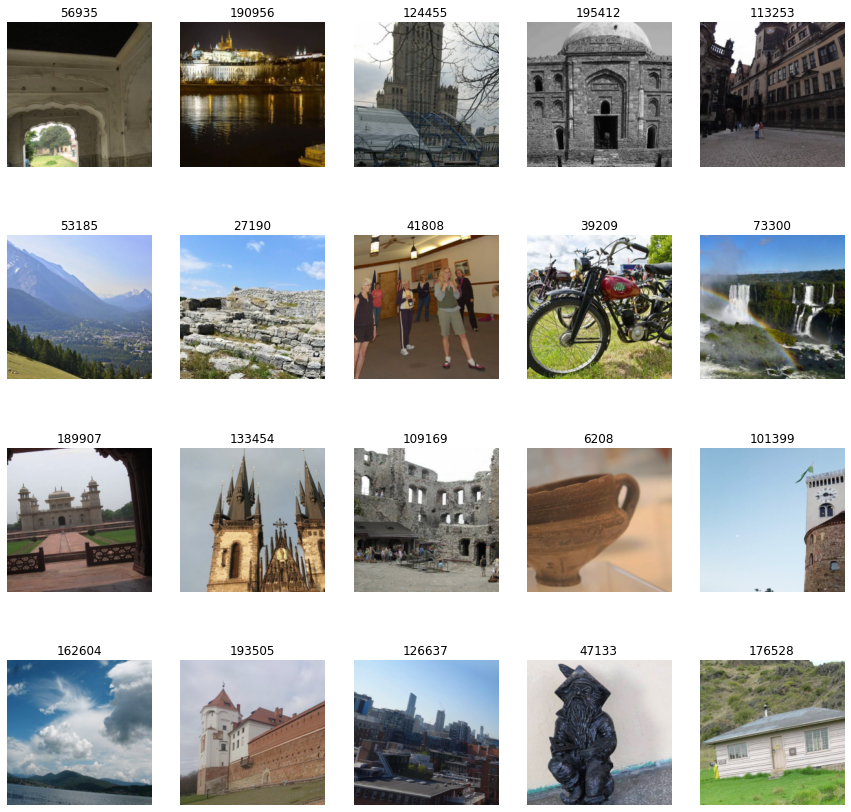

In [ ]:
dls = train_db.dataloaders(train_csv_sample)
dls.show_batch(max_n=20, figsize=(15,15))
# dls = train_db.dataloaders(train_csv)
# dls.show_batch(max_n=20, figsize=(15,15))

## Initial model on sample data

In [ ]:
# learn_sample_34 = cnn_learner(dls_sample, resnet34, metrics=Precision(average='micro'))
# learn_sample.fine_tune(2)

## ResNet 34

In [ ]:
# learn_sample_34 = cnn_learner(dls_sample, resnet34,
#                               metrics=Precision(average='micro'))#.to_fp16()
# lr_min,lr_steep = learn_sample_34.lr_find()

In [ ]:
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
# lr_use = (lr_min + lr_steep) / 2
# print(f"LR to be used/10: {lr_use:.2e}")

In [ ]:
# learn_sample_34.fit_one_cycle(5, lr_use)

In [ ]:
# learn_sample_34.unfreeze()

In [ ]:
# lr_min,lr_steep = learn_sample_34.lr_find()
# print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
# learn_sample_34.fit_one_cycle(10, lr_max=slice(lr_steep,lr_min))

In [ ]:
# learn_sample_34.recorder.plot_loss()

### Model interpretation for the sample model

In [ ]:
# interp_34 = ClassificationInterpretation.from_learner(learn_sample_34)
# interp_34.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# interp_34.most_confused(min_val=5)

In [ ]:
# interp_34.plot_top_losses(10, nrows=5)

### Save model

In [ ]:
# from pathlib import Path
# learn_sample_34.export(Path(f"{output_dir}/{output_model_dir}/landmark-recognition-2021_res34_{cur_time}.pkl"))

## ResNet50

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

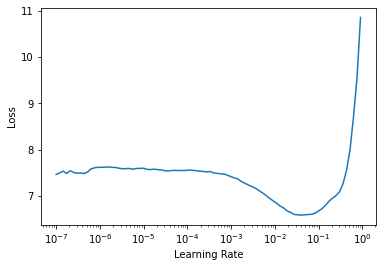

In [ ]:
# learn_sample_50 = cnn_learner(dls_sample, resnet50,
#                               metrics=Precision(average='micro'))#.to_fp16()
# lr_min,lr_steep = learn_sample_50.lr_find()
learn_res_50 = cnn_learner(dls, resnet50,
                              metrics=Precision(average='micro')).to_fp16()
lr_min,lr_steep = learn_res_50.lr_find()

In [ ]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
lr_use = (lr_min + lr_steep) / 2
print(f"LR to be used/10: {lr_use:.2e}")

Minimum/10: 3.98e-03, steepest point: 1.58e-02
LR to be used/10: 9.92e-03


In [ ]:
# learn_sample = cnn_learner(dls_sample, resnet34, metrics=Precision(average='micro'))
learn_res_50.fit_one_cycle(3, lr_use)

epoch,train_loss,valid_loss,precision_score,time
0,2.148305,1.851749,0.546751,29:28
1,1.329961,0.905816,0.765291,26:43
2,1.006175,0.672316,0.823272,26:47


In [ ]:
learn_res_50.unfreeze()

Minimum/10: 7.59e-08, steepest point: 6.31e-07


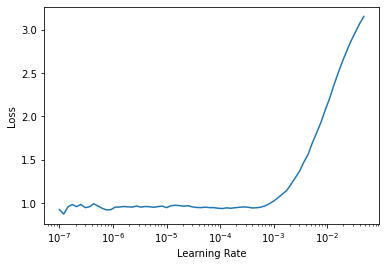

In [ ]:
lr_min,lr_steep = learn_res_50.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [ ]:
learn_res_50.fit_one_cycle(10, lr_max=slice(lr_steep,lr_min))

epoch,train_loss,valid_loss,precision_score,time
0,0.875420,0.671467,0.824865,28:14
1,0.889716,0.667635,0.825701,28:25
2,0.927517,0.664579,0.826139,28:17


KeyboardInterrupt: 

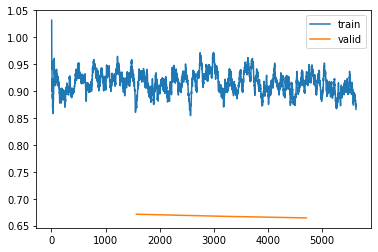

In [ ]:
learn_res_50.recorder.plot_loss()

### Model interpretation for the sample model

In [ ]:
interp_50 = ClassificationInterpretation.from_learner(learn_res_50)
interp_50.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp_50.most_confused(min_val=5)

In [ ]:
interp_50.plot_top_losses(10, nrows=5)

### Save model

In [ ]:
learn_res_50.export(Path(f"{output_dir}/{output_model_dir}/landmark-recognition-2021_res50_{cur_time}.pkl"))

## Inference

In [ ]:
cat_list = learn_res_50.dls.vocab
cat_list

In [ ]:
# pred_tensor = learn_res_50.predict(base_data_dir + '/' + test_dir+ '/'+'0/0/0/00084cdf8f600d00.jpg')
# f"{pred_tensor[0]} {pred_tensor[2].tolist()[pred_tensor[1].tolist()]}"

In [ ]:
# def get_inference_df(model, root_test_dir):
#     pred_list=[]
#     for dirname, _, filenames in os.walk(root_test_dir):
#         for filename in filenames:
#             pred_tensor = model.predict(os.path.join(dirname, filename))
#             pred_list.append((filename.split('.')[0],
#                               f"{pred_tensor[0]} {pred_tensor[2].tolist()[pred_tensor[1].tolist()]}"))
# #         if len(pred_list)>0: break
#     return pd.DataFrame(pred_list, columns=['id','landmarks'])

def get_predicted_data(learner, test_df, cat_list):
    test_dl = learner.dls.test_dl(test_df)
    prob_tensor, _, pred_tensor = learner.get_preds(dl = test_dl, with_decoded=True)
    pred_list = [f"{cat_list[pred_idx]} {prob_idx[pred_idx]}" 
                 for pred_idx, prob_idx in zip(pred_tensor,prob_tensor)]
    
    test_df['landmarks'] = pred_list
    return test_df
    

def get_inference_df(root_test_dir):
    path_list=[]
    for dirname, _, filenames in os.walk(root_test_dir):
        for filename in filenames:
            path_list.append((filename.split('.')[0],'0'))
#         if len(path_list)>0: break
    return pd.DataFrame(path_list, columns=['id','landmark_id'])
    

In [ ]:
test_df = get_inference_df(base_data_dir + '/' + test_dir+ '/')
test_df = add_file_path(test_df, test_dir)
test_df.head()

In [ ]:
pred_df = get_predicted_data(learn_res_50, test_df, cat_list)
pred_df.head()

In [ ]:
# pred_df = get_inference_df(learn_sample_50, base_data_dir + '/' + test_dir+ '/')
# pred_df.shape

In [ ]:
pred_df.to_csv(f"{output_dir}/landmark-recognition-2021_submission_{cur_time}.csv",
               index= False)

In [ ]:
# pred_df[['id','landmarks']].to_csv(f"{output_dir}/submission.csv",
#                index= False)